<a href="https://colab.research.google.com/github/anvithakp/ML-Google-Colab/blob/master/BERT_Multi_Class_Classification_Added_History.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BERT Multi-Class Classification with Liar-Liar dataset



####Brief summary before we go into the details

|Factor  |  Member |
|-----|-----|
| BERT Multi Class Classification |  Anvitha Karanam |  

####Comparision of F1 scores

Model  | F1 Score | 
-- | -- | 
Naive Bayes + Liar Liar| 0.22 | 
BERT + Liar Liar | 0.27 | 
BERT + Liar Liar + Truth History | 0.31
Naive Bayes + Liar Liar + Truth History + Web Scraping+ Amalgamation + Distillation | 0.46
BERT + Liar Liar + Truth History + Web Scraping + Amalgamation + Distillation | 0.59

# Part I - Dataset & Tokenization
---------------------------------

# Data Narrative

### Liar Liar Pants on Fire Dataset Description 

- Each file has 13 columns
    
    Column 1: the ID of the statement ([ID].json).
    
    Column 2: the statement.
    
    Column 3: the subject(s).
    
    Column 4: the speaker.
    
    Column 5: the speaker's job title.
    
    Column 6: the state info.
    
    Column 7: the party affiliation.
    
    Column 8-12: the total credit history count, including the current statement.
    
    Column 13: the context (venue / location of the speech or statement).


## S1. Setup


### 1.1. Connecting GPU


In order for torch to use the GPU, we need to identify and specify the GPU as the device. Later, in our training loop, we will load data onto the device. 

In [ ]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB


### 1.2. Installing `transformers` from huggingface



Next, let's install the [transformers](https://github.com/huggingface/transformers) package from Hugging Face which will give us a pytorch interface for working with BERT. 

In [ ]:
!pip install transformers

     |████████████████████████████████| 1.4MB 5.8MB/s 
     |████████████████████████████████| 2.9MB 52.2MB/s 
     |████████████████████████████████| 890kB 72.2MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=35f62cab2e6c1cddedb2c40e2f69fe080de327f0db80413b098c82866149b5ca
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


## S2. Retrieve & Inspect Dataset



In [ ]:
traindata  =  "https://raw.githubusercontent.com/anvithakp/AlternusVera/main/liar_dataset/train.tsv"
testdata = "https://raw.githubusercontent.com/anvithakp/AlternusVera/main/liar_dataset/test.tsv"
validdata = "https://raw.githubusercontent.com/anvithakp/AlternusVera/main/liar_dataset/valid.tsv"
politifactdata = "https://raw.githubusercontent.com/anvithakp/AlternusVera/main/Politifact/politifact.tsv"

In [ ]:
columns=["ID", "target", "text", "subjects", "speaker", "job", "state", "party", "barely_true_count", "false_count", "half_true_count", "mostly_true_count", "pants_on_fire_count", "target_names"]

In [ ]:
import pandas as pd
liar_train_df = pd.read_csv(traindata, sep='\t', header=None, names = columns, error_bad_lines=False)
liar_test_df = pd.read_csv(testdata, sep='\t',header=None, names = columns, error_bad_lines=False) 
liar_valid_df = pd.read_csv(validdata, sep='\t',header=None, names = columns, error_bad_lines=False) 
politifact = pd.read_csv(politifactdata, sep='\t',header=None, error_bad_lines=False) 

In [ ]:
politifact.head(5)

,0,1,2,3,4,5,6,7,8,9,10,11
0,NaN,meter,source,statement,context,tags,true,mostly-true,half-true,barely-true,false,pants-fire
1,0.0,false,Donald Trump,"""Big victory moments ago in the State of Nevad...",a tweet,"['National', 'Nevada', 'Elections', 'Donald Tr...",35,84,119,186,333,151
2,1.0,fire,Donald Trump,“The recent statement by Chris Krebs on the se...,a Tweet,"['National', 'Nevada', 'Elections', 'Donald Tr...",35,84,119,186,333,151
3,2.0,mostly-true,Kim Reynolds,"""If you can’t get a test through Test Iowa, th...",a press conference,"['Health Care', 'Iowa', 'Coronavirus', 'Kim Re...",0,3,0,0,0,0
4,3.0,fire,Instagram posts,Vaccines “will remove parts of your DNA and re...,an Instagram post,"['Public Health', 'Science', 'Facebook Fact-ch...",1,0,3,9,30,12


In [ ]:
politifact = politifact.drop([0])
politifact = politifact.reset_index(drop=True)
politifact = politifact.rename(columns={0: "ID", 1: "target",2: "source", 3: "text",4: "target_names", 5: "details",6: "true_count",7: "mostly_true_count", 8: "half_true_count",9: "barely_true_count", 10: "false_count",11:"pants_on_fire_count"}, errors="raise")
politifact.head(5)

,ID,target,source,text,target_names,details,true_count,mostly_true_count,half_true_count,barely_true_count,false_count,pants_on_fire_count
0,0.0,false,Donald Trump,"""Big victory moments ago in the State of Nevad...",a tweet,"['National', 'Nevada', 'Elections', 'Donald Tr...",35,84,119,186,333,151
1,1.0,fire,Donald Trump,“The recent statement by Chris Krebs on the se...,a Tweet,"['National', 'Nevada', 'Elections', 'Donald Tr...",35,84,119,186,333,151
2,2.0,mostly-true,Kim Reynolds,"""If you can’t get a test through Test Iowa, th...",a press conference,"['Health Care', 'Iowa', 'Coronavirus', 'Kim Re...",0,3,0,0,0,0
3,3.0,fire,Instagram posts,Vaccines “will remove parts of your DNA and re...,an Instagram post,"['Public Health', 'Science', 'Facebook Fact-ch...",1,0,3,9,30,12
4,4.0,half-true,Scott Fitzgerald,The 2020 election is in “recount territory” an...,a TV interview,"['Elections', 'States', 'Wisconsin', 'Scott Fi...",0,0,2,3,2,0


In [ ]:
politifact['text'][0]

'"Big victory moments ago in the State of Nevada. The all Democrat County Commissioner race, on same ballot as President, just thrown out because of large scale voter discrepancy."'

In [ ]:
liar_train_df.head(5)

,ID,target,text,subjects,speaker,job,state,party,barely_true_count,false_count,half_true_count,mostly_true_count,pants_on_fire_count,target_names
0,2635.json,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer
1,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.
2,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver
3,1123.json,false,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release
4,9028.json,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN


In [ ]:
liar_test_df

,ID,target,text,subjects,speaker,job,state,party,barely_true_count,false_count,half_true_count,mostly_true_count,pants_on_fire_count,target_names
0,11972.json,true,Building a wall on the U.S.-Mexico border will...,immigration,rick-perry,Governor,Texas,republican,30,30,42,23,18,Radio interview
1,11685.json,false,Wisconsin is on pace to double the number of l...,jobs,katrina-shankland,State representative,Wisconsin,democrat,2,1,0,0,0,a news conference
2,11096.json,false,Says John McCain has done nothing to help the ...,"military,veterans,voting-record",donald-trump,President-Elect,New York,republican,63,114,51,37,61,comments on ABC's This Week.
3,5209.json,half-true,Suzanne Bonamici supports a plan that will cut...,"medicare,message-machine-2012,campaign-adverti...",rob-cornilles,consultant,Oregon,republican,1,1,3,1,1,a radio show
4,9524.json,pants-fire,When asked by a reporter whether hes at the ce...,"campaign-finance,legal-issues,campaign-adverti...",state-democratic-party-wisconsin,NaN,Wisconsin,democrat,5,7,2,2,7,a web video
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1262,7334.json,half-true,Says his budget provides the highest state fun...,education,rick-scott,Governor,Florida,republican,28,23,38,34,7,a news conference
1263,9788.json,barely-true,Ive been here almost every day.,"civil-rights,crime,criminal-justice",jay-nixon,Governor,Missouri,democrat,2,0,0,1,0,"on ABC's ""This Week"""
1264,10710.json,barely-true,"In the early 1980s, Sen. Edward Kennedy secret...","bipartisanship,congress,foreign-policy,history",mackubin-thomas-owens,"senior fellow, Foreign Policy Research Institute",Rhode Island,columnist,1,0,0,0,0,a commentary in The Providence Journal
1265,3186.json,barely-true,Says an EPA permit languished under Strickland...,"environment,government-efficiency",john-kasich,"Governor of Ohio as of Jan. 10, 2011",Ohio,republican,9,8,10,18,3,a news conference


In [ ]:
liar_test_df.head(5)

,ID,target,text,subjects,speaker,job,state,party,barely_true_count,false_count,half_true_count,mostly_true_count,pants_on_fire_count,target_names
0,11972.json,true,Building a wall on the U.S.-Mexico border will...,immigration,rick-perry,Governor,Texas,republican,30,30,42,23,18,Radio interview
1,11685.json,false,Wisconsin is on pace to double the number of l...,jobs,katrina-shankland,State representative,Wisconsin,democrat,2,1,0,0,0,a news conference
2,11096.json,false,Says John McCain has done nothing to help the ...,"military,veterans,voting-record",donald-trump,President-Elect,New York,republican,63,114,51,37,61,comments on ABC's This Week.
3,5209.json,half-true,Suzanne Bonamici supports a plan that will cut...,"medicare,message-machine-2012,campaign-adverti...",rob-cornilles,consultant,Oregon,republican,1,1,3,1,1,a radio show
4,9524.json,pants-fire,When asked by a reporter whether hes at the ce...,"campaign-finance,legal-issues,campaign-adverti...",state-democratic-party-wisconsin,NaN,Wisconsin,democrat,5,7,2,2,7,a web video


In [ ]:
liar_valid_df.head(5)

,ID,target,text,subjects,speaker,job,state,party,barely_true_count,false_count,half_true_count,mostly_true_count,pants_on_fire_count,target_names
0,12134.json,barely-true,We have less Americans working now than in the...,"economy,jobs",vicky-hartzler,U.S. Representative,Missouri,republican,1,0,1,0,0,an interview with ABC17 News
1,238.json,pants-fire,"When Obama was sworn into office, he DID NOT u...","obama-birth-certificate,religion",chain-email,NaN,NaN,none,11,43,8,5,105,NaN
2,7891.json,false,Says Having organizations parading as being so...,"campaign-finance,congress,taxes",earl-blumenauer,U.S. representative,Oregon,democrat,0,1,1,1,0,a U.S. Ways and Means hearing
3,8169.json,half-true,Says nearly half of Oregons children are poor.,poverty,jim-francesconi,Member of the State Board of Higher Education,Oregon,none,0,1,1,1,0,an opinion article
4,929.json,half-true,On attacks by Republicans that various program...,"economy,stimulus",barack-obama,President,Illinois,democrat,70,71,160,163,9,interview with CBS News


In [ ]:
liar_valid_df.describe()

,barely_true_count,false_count,half_true_count,mostly_true_count,pants_on_fire_count
count,1284.000000,1284.000000,1284.000000,1284.000000,1284.000000
mean,11.804517,13.832555,17.225078,16.595794,6.881620
std,19.021708,24.546884,35.622818,35.966699,17.597474
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.750000,0.000000,0.000000
50%,3.000000,3.000000,3.000000,3.000000,1.000000
75%,12.000000,17.000000,13.000000,12.000000,5.000000
max,70.000000,114.000000,160.000000,163.000000,105.000000


Concatenating the validation and train data

In [ ]:
liar_train_df = liar_train_df.append(liar_valid_df, ignore_index=True)

## S3. Data Cleaning and Preprocessing

In [ ]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from sklearn import metrics
from nltk.corpus import stopwords
from gensim.models import Word2Vec
import re

import re

def cleaning(raw_data):
    import nltk
    
    # 1. Remove non-letters/Special Characters and Punctuations
    data = re.sub("[^a-zA-Z]", " ", str(raw_data))
    
    # 2. Convert to lower case.
    data =  data.lower()
    
    # 3. Tokenize.
    data_words = nltk.word_tokenize(data)
    
    # 4. Convert the stopwords list to "set" data type.
    stops = set(nltk.corpus.stopwords.words("english"))
    
    # 5. Remove stop words. 
    words = [w for w in  data_words  if not w in stops]
    
    # 6. Lemmentize 
    wordnet_lem = [ WordNetLemmatizer().lemmatize(w) for w in words ]
    
    # 7. Stemming
    stems = [nltk.stem.SnowballStemmer('english').stem(w) for w in wordnet_lem ]
    
    # 8. Join the stemmed words back into one string separated by space, and return the result.
    return " ".join(stems)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [ ]:
deleterows = []
for i in range(len(politifact)):
    if politifact.loc[i, 'target'] == "full-flop": 
        deleterows.append(i)
    elif politifact.loc[i, 'target'] == "half-flip": 
        deleterows.append(i)
    elif politifact.loc[i, 'target'] == "no-flip": 
        deleterows.append(i)
      
politifact = politifact.drop(deleterows)
politifact = politifact.reset_index(drop=True)

Dropping null value rows from the dataframe

In [ ]:
liar_test_df = liar_test_df.dropna(subset=['text', 'speaker','subjects','barely_true_count','false_count','half_true_count','mostly_true_count','pants_on_fire_count'])
liar_test_df = liar_test_df.reset_index(drop=True)
liar_train_df = liar_train_df.dropna(subset=['text', 'speaker','subjects','barely_true_count','false_count','half_true_count','mostly_true_count','pants_on_fire_count'])
liar_train_df = liar_train_df.reset_index(drop=True)
politifact = politifact.dropna(subset=['text', 'source','details','target_names','barely_true_count','false_count','half_true_count','mostly_true_count','pants_on_fire_count','true_count'])
politifact = politifact.reset_index(drop=True)

In [ ]:
politifact_new = politifact.copy()
politifact_new['data'] = politifact['text'] + politifact['target_names'] + politifact['source'] + politifact['details']
politifact_new = politifact_new.drop(columns=['ID', 'text','source','details','true_count'])
politifact_new['data'] = politifact_new["data"].apply(cleaning) 
politifact_new.head()


,target,target_names,mostly_true_count,half_true_count,barely_true_count,false_count,pants_on_fire_count,data
0,false,a tweet,84,119,186,333,151,big victori moment ago state nevada democrat c...
1,fire,a Tweet,84,119,186,333,151,recent statement chris kreb secur elect high i...
2,mostly-true,a press conference,3,0,0,0,0,get test test iowa multipl site doctor clinic ...
3,fire,an Instagram post,0,3,9,30,12,vaccin remov part dna replac genet code techno...
4,half-true,a TV interview,0,2,3,2,0,elect recount territori seen elect chang resul...


In [ ]:
bertcols = ['target','target_names','data']
politifact_train = politifact_new[bertcols]
politifact_train

,target,target_names,data
0,false,a tweet,big victori moment ago state nevada democrat c...
1,fire,a Tweet,recent statement chris kreb secur elect high i...
2,mostly-true,a press conference,get test test iowa multipl site doctor clinic ...
3,fire,an Instagram post,vaccin remov part dna replac genet code techno...
4,half-true,a TV interview,elect recount territori seen elect chang resul...
...,...,...,...
17152,half-true,a CNN interview,depart justic obama administr disagre decis ju...
17153,true,a press release.,presid obama percent gm union buddi almost per...
17154,mostly-false,a speech,day sinc passag econom stimulus save creat nea...
17155,true,a released statement,nuclear test conduct nation time earth th nucl...


In [ ]:
#Combining the text and speaker columns into one statement and applying data cleaning
liar_test_new = liar_test_df.copy()
liar_test_new['data']=liar_test_df['text']+liar_test_df['speaker']+liar_test_df['subjects']+liar_test_df['target_names']
liar_test_new = liar_test_new.drop(columns=['ID', 'text','subjects','speaker','job','state','party','barely_true_count','false_count','half_true_count','mostly_true_count','pants_on_fire_count'])
liar_test_new['data'] = liar_test_new['data'].apply(cleaning) 

liar_train_new = liar_train_df.copy()
liar_train_new['data']=liar_train_df['text']+liar_train_df['speaker']+liar_train_df['subjects']+liar_train_df['target_names']
liar_train_new = liar_train_new.drop(columns=['ID', 'text','subjects','speaker','job','state','party','barely_true_count','false_count','half_true_count','mostly_true_count','pants_on_fire_count'])
liar_train_new['data'] = liar_train_new['data'].apply(cleaning) 


In [ ]:
for i in range(len(liar_test_new)):
    if liar_test_new.loc[i, 'target'] == "true": #REAL => 0
        liar_test_new.loc[i, 'target'] = 0
    elif liar_test_new.loc[i, 'target'] == "mostly-true": #mostly-true => 1
        liar_test_new.loc[i, 'target'] = 1
    elif liar_test_new.loc[i, 'target'] == "barely-true": #barely-true => 2
        liar_test_new.loc[i, 'target'] = 2
    elif liar_test_new.loc[i, 'target'] == "half-true": #half-true => 3
        liar_test_new.loc[i, 'target'] = 3
    elif liar_test_new.loc[i, 'target'] == "false": #false => 4
        liar_test_new.loc[i, 'target'] = 4
    elif liar_test_new.loc[i, 'target'] == "pants-fire": #pants-fire => 5
        liar_test_new.loc[i, 'target'] = 5            
    if liar_test_new.loc[i, 'data'] == "":
        liar_test_new = liar_test_new.drop([i])
liar_test_new.head()

,target,target_names,data
0,0,Radio interview,build wall u mexico border take liter year ric...
1,4,a news conference,wisconsin pace doubl number layoff year katrin...
2,4,comments on ABC's This Week.,say john mccain done noth help vet donald trum...
3,3,a radio show,suzann bonamici support plan cut choic medicar...
4,5,a web video,ask report whether he center crimin scheme vio...


In [ ]:
for i in range(len(liar_train_new)):
    if liar_train_new.loc[i, 'target'] == "true": #true => 0
        liar_train_new.loc[i, 'target'] = 0
    elif liar_train_new.loc[i, 'target'] == "mostly-true": #mostly true => 1
        liar_train_new.loc[i, 'target'] = 1
    elif liar_train_new.loc[i, 'target'] == "barely-true": #barely-true => 2
        liar_train_new.loc[i, 'target'] = 2
    elif liar_train_new.loc[i, 'target'] == "half-true": #half-true => 3
        liar_train_new.loc[i, 'target'] = 3
    elif liar_train_new.loc[i, 'target'] == "false": #false => 4
        liar_train_new.loc[i, 'target'] = 4
    elif liar_train_new.loc[i, 'target'] == "pants-fire": #pants-fire => 5
        liar_train_new.loc[i, 'target'] = 5            
    if liar_train_new.loc[i, 'data'] == "":
        liar_train_new = liar_train_new.drop([i])
liar_train_new.head()

,target,target_names,data
0,4,a mailer,say anni list polit group support third trimes...
1,3,a floor speech.,declin coal start start natur gas took start b...
2,1,Denver,hillari clinton agre john mccain vote give geo...
3,4,a news release,health care reform legisl like mandat free sex...
4,3,an interview on CNN,econom turnaround start end term charli criste...


In [ ]:
politifact_train.head()

,target,target_names,data
0,false,a tweet,big victori moment ago state nevada democrat c...
1,fire,a Tweet,recent statement chris kreb secur elect high i...
2,mostly-true,a press conference,get test test iowa multipl site doctor clinic ...
3,fire,an Instagram post,vaccin remov part dna replac genet code techno...
4,half-true,a TV interview,elect recount territori seen elect chang resul...


In [ ]:
for i in range(len(politifact_train)):
    if politifact_train.loc[i, 'target'] == "true": #REAL => 0
        politifact_train.loc[i, 'target'] = 0
    elif politifact_train.loc[i, 'target'] == "mostly-true": #mostly-true => 1
        politifact_train.loc[i, 'target'] = 1
    elif politifact_train.loc[i, 'target'] == "mostly-false": #barely-true => 2
        politifact_train.loc[i, 'target'] = 2
    elif politifact_train.loc[i, 'target'] == "half-true": #half-true => 3
        politifact_train.loc[i, 'target'] = 3
    elif politifact_train.loc[i, 'target'] == "false": #false => 4
        politifact_train.loc[i, 'target'] = 4
    elif politifact_train.loc[i, 'target'] == "fire": #pants-fire => 5
        politifact_train.loc[i, 'target'] = 5            
    if politifact_train.loc[i, 'data'] == "":
        politifact_train = politifact_train.drop([i])
politifact_train

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del 

,target,target_names,data
0,4,a tweet,big victori moment ago state nevada democrat c...
1,5,a Tweet,recent statement chris kreb secur elect high i...
2,1,a press conference,get test test iowa multipl site doctor clinic ...
3,5,an Instagram post,vaccin remov part dna replac genet code techno...
4,3,a TV interview,elect recount territori seen elect chang resul...
...,...,...,...
17152,3,a CNN interview,depart justic obama administr disagre decis ju...
17153,0,a press release.,presid obama percent gm union buddi almost per...
17154,2,a speech,day sinc passag econom stimulus save creat nea...
17155,0,a released statement,nuclear test conduct nation time earth th nucl...


### 3.1 Data Enriching with scrapped Data from Politifact

In [ ]:
liar_train_new = liar_train_new.append(politifact_train, ignore_index=True)

##S4. Visualizing with WordCloud

In [ ]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

%matplotlib inline

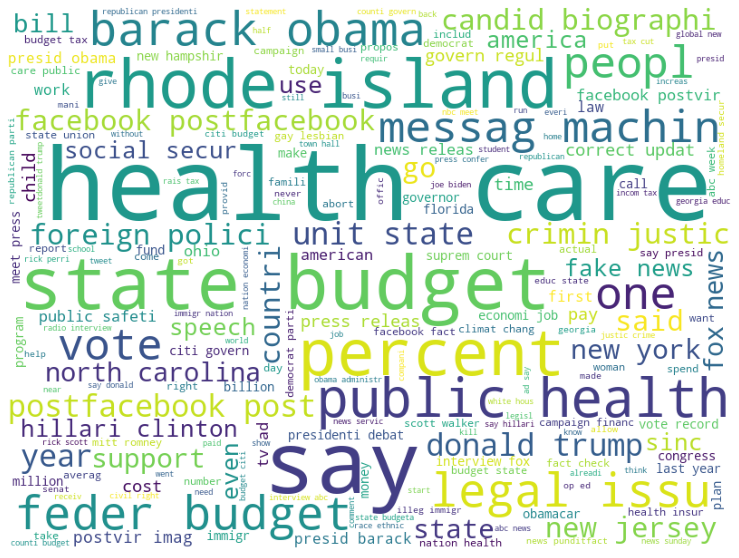

In [ ]:
def cloud(data,backgroundcolor = 'white', width = 800, height = 600):
    wordcloud = WordCloud(stopwords = STOPWORDS, background_color = backgroundcolor,
                         width = width, height = height).generate(data)
    plt.figure(figsize = (15, 10))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()
    
cloud(' '.join(liar_train_new['data']))

##S5. Distillation Using LDA Topic Modeling

In [ ]:
data_lda = liar_train_new[['data']]
test_lda = liar_test_new[['data']]
data_lda.head(10)

,data
0,say anni list polit group support third trimes...
1,declin coal start start natur gas took start b...
2,hillari clinton agre john mccain vote give geo...
3,health care reform legisl like mandat free sex...
4,econom turnaround start end term charli criste...
5,chicago bear start quarterback last year total...
6,jim dunnam live district repres year republica...
7,person stage work activ last year pass along r...
8,howev took million oregon lotteri fund port ne...
9,say gop primari oppon glenn grothman joe leibh...


Split the clean news into list of words

In [ ]:
processed_docs = data_lda['data'].map(lambda doc: doc.split(" "))

Function to convert text to word tokens from cleaned dataset

In [ ]:
def get_word_tokens(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if len(token) > 3:
            result.append(token)
    return result

Function to build the dictionary and tokenized docs for given feature

In [ ]:
def get_dictionary_print_words(dataframe,colname):
    dictionary_gensim = gensim.corpora.Dictionary(processed_docs)
    count = 0
    print('######## DICTIONARY Words and occurences ########')
    for k, v in dictionary_gensim.iteritems():
        print(k, v)
        count += 1
        if count > 10:
            break
    dictionary_gensim.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)
    return dictionary_gensim, tokenized_docs_local

Function to build bow_corpus from dictionary and tokenized_docs

In [ ]:
def get_bow_corpus_print_sample(dataframe,colname):
    dictionary_gensim, tokenized_docs_local = get_dictionary_print_words(dataframe, colname)
    bow_corpus_local = [dictionary_gensim.doc2bow(doc) for doc in tokenized_docs_local]
    bow_doc_local_0 = bow_corpus_local[0]
    print('\n ######## BOW VECTOR FIRST ITEM ########')
    print(bow_doc_local_0)
    print('\n ######## PREVIEW BOW ########')
    for i in range(len(bow_doc_local_0)):
        print("Word {} (\"{}\") appears {} time.".format(bow_doc_local_0[i][0], 
                                               dictionary_gensim[bow_doc_local_0[i][0]], bow_doc_local_0[i][1]))
    return bow_corpus_local, dictionary_gensim

Function to build tfidf_corpus from bow_corpus

In [ ]:
def get_lda_model_topics_topwords_print_top_topics(bow_corpusforlda,numtopics,dictionaryforlda):
    lda_model = gensim.models.LdaMulticore(bow_corpusforlda, num_topics=numtopics, id2word=dictionaryforlda, passes=2, workers=2, random_state=1)
    lda_all_topics=lda_model.show_topics(num_topics=numtopics, num_words=10,formatted=False)
    lda_topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in lda_all_topics]

    #Below Code Prints Topics and Words
    for topic,words in lda_topics_words:
        print(str(topic)+ "::"+ str(words))
    return lda_model,lda_topics_words

In [ ]:
def get_tfidf_corpus_print_sample(bow_corpus_local):
    from gensim import corpora, models
    tfidf = models.TfidfModel(bow_corpus_local)
    tfidf_corpus_local = tfidf[bow_corpus_local]
       
    from pprint import pprint
    for doc in tfidf_corpus_local:
        pprint(doc)
        break
    return tfidf_corpus_local

Function to run ldamodel and print top topics

In [ ]:
def get_lda_model_print_top_topics(bow_corpusforlda,numtopics,dictionaryforlda):
    lda_model = gensim.models.LdaMulticore(bow_corpusforlda, num_topics=numtopics, id2word=dictionaryforlda, passes=2, workers=2)
    lda_all_topics=lda_model.show_topics(num_topics=numtopics, num_words=6,formatted=False)
    lda_topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in lda_all_topics]

    #Below Code Prints Topics and Words
    for topic,words in lda_topics_words:
        print(str(topic)+ "::"+ str(words))
    return lda_model

Function to enrich data with lda topics, lda topics score, top words

In [ ]:
def identify_topic_number_score_label_topwords(text,dictionary_local,lda_model_local,lda_topics_top_words_local):
    bow_vector_local = dictionary_local.doc2bow(get_word_tokens(text))
    topic_number_local, topic_score_local = sorted(
        lda_model_local[bow_vector_local], key=lambda tup: -1*tup[1])[0]
    #print (topic_number_local, topic_score_local)
    return pd.Series([topic_number_local, topic_score_local," ".join(lda_topics_top_words_local[int(topic_number_local)][1])])

In [ ]:
def update_lda_results_to_dataset(dataframe,topiccolnames,coltoapplylda,colnamedictionary,colnameldamodel, colnameldatopwords):
    dataframe[topiccolnames] = dataframe.apply(
    lambda row: identify_topic_number_score_label_topwords(
        row[coltoapplylda],colnamedictionary,colnameldamodel,
        colnameldatopwords), axis=1)
    return dataframe

In [ ]:
import gensim
from gensim.models import Word2Vec


In [ ]:
tokenized_docs_local = data_lda['data'].map(get_word_tokens) 

In [ ]:
bow_corpus_text, dictionary_text = get_bow_corpus_print_sample(data_lda,
                                                                      'data')

######## DICTIONARY Words and occurences ########
0 abort
1 anni
2 bohacabortiona
3 demand
4 dwayn
5 group
6 list
7 mailer
8 polit
9 say
10 support

 ######## BOW VECTOR FIRST ITEM ########
[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (7, 1), (8, 1)]

 ######## PREVIEW BOW ########
Word 0 ("abort") appears 1 time.
Word 1 ("demand") appears 1 time.
Word 2 ("group") appears 1 time.
Word 3 ("list") appears 1 time.
Word 4 ("mailer") appears 1 time.
Word 5 ("polit") appears 1 time.
Word 7 ("support") appears 1 time.
Word 8 ("third") appears 1 time.


In [ ]:
lda_model_text, lda_text_topic_words = get_lda_model_topics_topwords_print_top_topics(
    bow_corpus_text, 10 ,dictionary_text)

0::['texa', 'vote', 'florida', 'nation', 'elect', 'bill', 'citi', 'perri', 'republican', 'hous']
1::['health', 'care', 'nation', 'bill', 'plan', 'insur', 'reform', 'medicar', 'would', 'campaign']
2::['trump', 'nation', 'crime', 'justic', 'candid', 'crimin', 'texa', 'immigr', 'biographi', 'court']
3::['nation', 'news', 'health', 'obama', 'care', 'presid', 'percent', 'american', 'week', 'interview']
4::['percent', 'nation', 'texa', 'economi', 'famili', 'florida', 'bennett', 'incom', 'georgia', 'state']
5::['state', 'budget', 'island', 'rhode', 'wisconsin', 'public', 'educ', 'scott', 'texa', 'georgia']
6::['facebook', 'immigr', 'post', 'show', 'nation', 'punditfact', 'florida', 'imag', 'polici', 'health']
7::['nation', 'campaign', 'state', 'budget', 'secur', 'stimulus', 'economi', 'social', 'ohio', 'obama']
8::['obama', 'nation', 'presid', 'barack', 'texa', 'health', 'elect', 'speech', 'govern', 'first']
9::['budget', 'year', 'state', 'interview', 'texa', 'nation', 'educ', 'florida', 'fed

In [ ]:
tfidf_corpus_text = get_tfidf_corpus_print_sample(bow_corpus_text)


[(0, 0.27050404658637783),
 (1, 0.4495317543243902),
 (2, 0.3656705173253568),
 (3, 0.396895657707567),
 (4, 0.38182465247775266),
 (5, 0.32415233281387557),
 (7, 0.25357437059573),
 (8, 0.3440100445551843)]


In [ ]:
semisupervised_topic_labels = ['topic0','topic1','topic2','topic3','topic4','topic5','topic6','topic7','topic8','topic9']

In [ ]:
topiccolnames = ['topic_number','lda_score','topic_top_words']
data_lda = update_lda_results_to_dataset(
    data_lda, topiccolnames,'data', dictionary_text, lda_model_text, lda_text_topic_words)
del data_lda['lda_score']
data_lda.head()

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


,data,topic_number,topic_top_words
0,say anni list polit group support third trimes...,2,trump nation crime justic candid crimin texa i...
1,declin coal start start natur gas took start b...,9,budget year state interview texa nation educ f...
2,hillari clinton agre john mccain vote give geo...,7,nation campaign state budget secur stimulus ec...
3,health care reform legisl like mandat free sex...,1,health care nation bill plan insur reform medi...
4,econom turnaround start end term charli criste...,9,budget year state interview texa nation educ f...


In [ ]:
data_lda

,data,topic_number,topic_top_words
0,say anni list polit group support third trimes...,2,trump nation crime justic candid crimin texa i...
1,declin coal start start natur gas took start b...,9,budget year state interview texa nation educ f...
2,hillari clinton agre john mccain vote give geo...,7,nation campaign state budget secur stimulus ec...
3,health care reform legisl like mandat free sex...,1,health care nation bill plan insur reform medi...
4,econom turnaround start end term charli criste...,9,budget year state interview texa nation educ f...
...,...,...,...
28674,depart justic obama administr disagre decis ju...,3,nation news health obama care presid percent a...
28675,presid obama percent gm union buddi almost per...,3,nation news health obama care presid percent a...
28676,day sinc passag econom stimulus save creat nea...,7,nation campaign state budget secur stimulus ec...
28677,nuclear test conduct nation time earth th nucl...,9,budget year state interview texa nation educ f...


In [ ]:
topiccols = ['topic_top_words'] 
liar_train_new = liar_train_new.join(data_lda[topiccols])
liar_train_new

,target,target_names,data,topic_top_words
0,4,a mailer,say anni list polit group support third trimes...,trump nation crime justic candid crimin texa i...
1,3,a floor speech.,declin coal start start natur gas took start b...,budget year state interview texa nation educ f...
2,1,Denver,hillari clinton agre john mccain vote give geo...,nation campaign state budget secur stimulus ec...
3,4,a news release,health care reform legisl like mandat free sex...,health care nation bill plan insur reform medi...
4,3,an interview on CNN,econom turnaround start end term charli criste...,budget year state interview texa nation educ f...
...,...,...,...,...
28674,3,a CNN interview,depart justic obama administr disagre decis ju...,nation news health obama care presid percent a...
28675,0,a press release.,presid obama percent gm union buddi almost per...,nation news health obama care presid percent a...
28676,2,a speech,day sinc passag econom stimulus save creat nea...,nation campaign state budget secur stimulus ec...
28677,0,a released statement,nuclear test conduct nation time earth th nucl...,budget year state interview texa nation educ f...


In [ ]:
liar_train_new['data'] = liar_train_new['data'] + liar_train_new['topic_top_words']
liar_train_new = liar_train_new.drop(columns=['topic_top_words'])
liar_train_new

,target,target_names,data
0,4,a mailer,say anni list polit group support third trimes...
1,3,a floor speech.,declin coal start start natur gas took start b...
2,1,Denver,hillari clinton agre john mccain vote give geo...
3,4,a news release,health care reform legisl like mandat free sex...
4,3,an interview on CNN,econom turnaround start end term charli criste...
...,...,...,...
28674,3,a CNN interview,depart justic obama administr disagre decis ju...
28675,0,a press release.,presid obama percent gm union buddi almost per...
28676,2,a speech,day sinc passag econom stimulus save creat nea...
28677,0,a released statement,nuclear test conduct nation time earth th nucl...


Encoding Data into Bunch to suit BERT model processing

In [ ]:
import sklearn.utils
from sklearn.utils import Bunch
tlabels = liar_test_new['target'].to_numpy()
#labels = labels.to_numpy() 
type(tlabels)
tdata = liar_test_new['data'].tolist()
type(tdata)
tdata_names = liar_test_new['target_names'].tolist()
test = Bunch(target=tlabels, data=tdata, target_names=tdata_names)
test.target = test.target.astype(int)

In [ ]:
import sklearn.utils
from sklearn.utils import Bunch
labels = liar_train_new['target'].to_numpy()
#labels = labels.to_numpy() 
type(labels)
data = liar_train_new['data'].tolist()
print(type(data))
data_names = liar_train_new['target_names'].tolist()
train = Bunch(target=labels, data=data, target_names=data_names)
train.target = train.target.astype(int)

<class 'list'>


In [ ]:
import textwrap
import random

# Wrap text to 80 characters.
wrapper = textwrap.TextWrapper(width=80) 

# Randomly choose some examples.
for i in range(10):
    
    # Choose a random sample by index.
    j = random.choice(range(len(train.data)))
    # Get the text as 'x' and the label integer as 'y'.
    x = train.data[j]
    print(len(x))
    y = train.target[j]

    # Print out the name of the category and the text.
    print('')
    print('========', train.target_names[y], '========')
    print(wrapper.fill(x))
    print('')


256

======== a floor speech. ========
sixti million american depend social secur one third senior america depend
social secur percent incom mike huckabeeincom retir social securitya speech gov
rick scott econom summit orlandonation campaign state budget secur stimulus
economi social ohio obama

216

======== an interview on CNN ========
say award win milwauke public school teacher megan sampson laid gov scott walker
cut state aid educ columngail collin educ labor wisconsin gail collinstate
budget island rhode wisconsin public educ scott texa georgia

225

======== a floor speech. ========
say employ still allow pay peopl disabl minimum wage speech democrat nation
conventiontom harkin nation civil right disabl incom job regul worker tom
harkinnation campaign state budget secur stimulus economi social ohio obama

212

======== an interview on CNN ========
claim suprem court justic ruth bader ginsburg said prefer south african
constitut unit state constitut rick santorumleg issu suprem c

Let's look at the classes to see how balanced they are.

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, '# of Training Samples')

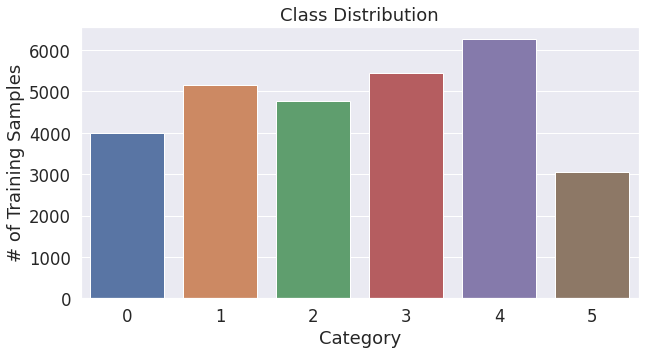

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (10,5)


# Plot the number of tokens of each length.
sns.countplot(train.target)
plt.title('Class Distribution')
plt.xlabel('Category')
plt.ylabel('# of Training Samples')


They look pretty even, except for maybe class 5, which corresponds to 'a an online opinion-piece'.

In [ ]:
train.target_names[5]

'a an online opinion-piece'

## S6. Tokenization

BERT has a maximum input length of 512 tokens, so we'll need to truncate any comments which are longer than this.


### 6.1. Load BertTokenizer

preprocess the data for BERT to be able to analyze it.

In order to see the distribution of comment lengths *in terms of BERT tokens*, we'll need to first apply the BertTokenizer to the dataset.

In [ ]:
from transformers import BertTokenizer

# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Loading BERT tokenizer...


### 6.2. Sequence Length Distribution

To decide on a truncation strategy for this dataset, let's first look at the distribution of sequence lengths.

To do this, our first step is to tokenize all of the samples in the training set.

**Tokenize All Samples**

The `tokenizer.encode` function combines multiple steps for us:
1. Split the sentence into tokens.
2. Add the special `[CLS]` and `[SEP]` tokens.
3. Map the tokens to their IDs.

In [ ]:
import numpy as np

# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []

# Record the length of each sequence (in terms of BERT tokens).
lengths = []

print('Tokenizing comments...')

# For every sentence...
for sen in train.data:
    
    # Report progress.
    if ((len(input_ids) % 20000) == 0):
        print('  Read {:,} comments.'.format(len(input_ids)))
    
    # `encode` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    encoded_sent = tokenizer.encode(
                        sen,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 512,          # Truncate all sentences.                        
                        #return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.
    input_ids.append(encoded_sent)

    # Record the non-truncated length.
    lengths.append(len(encoded_sent))

print('DONE.')
print('{:>10,} comments'.format(len(input_ids)))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Tokenizing comments...
  Read 0 comments.
  Read 20,000 comments.
DONE.
    28,679 comments


Print the min, max and median sentence lengths

In [ ]:
print('   Min length: {:,} tokens'.format(min(lengths)))
print('   Max length: {:,} tokens'.format(max(lengths)))
print('Median length: {:,} tokens'.format(np.median(lengths)))

   Min length: 17 tokens
   Max length: 510 tokens
Median length: 46.0 tokens


What percentage are over the 512 limit?

In [ ]:
num_over = 0

# For all of the length values...
for length in lengths:
    # Tally if it's over 512.
    if length > 512:
        num_over += 1

print('{:,} of {:,} comments will be truncated ({:.2%})'.format(num_over, len(lengths), float(num_over) / float(len(lengths))))

0 of 28,679 comments will be truncated (0.00%)


To further analyze it, let's plot the distribution.


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, '# of Comments')

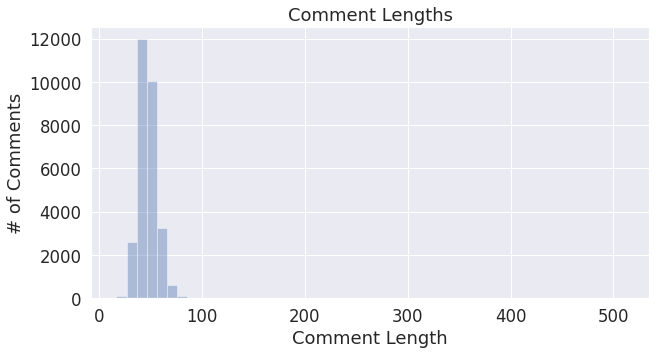

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (10,5)

# Truncate any comment lengths greater than 512.
trunc_lengths = [min(l, 512) for l in lengths]

# Plot the distribution of comment lengths.
sns.distplot(trunc_lengths, kde=False, rug=False)

# Alternatively, you might try using a log scale on the x-axis, but this is 
# tricky. See here for one approach:
# https://stackoverflow.com/questions/47850202/plotting-a-histogram-on-a-log-scale-with-matplotlib?rq=1
#plt.xscale('log')

plt.title('Comment Lengths')
plt.xlabel('Comment Length')
plt.ylabel('# of Comments')


In [ ]:
col = ['barely_true_count','false_count','half_true_count','mostly_true_count','pants_on_fire_count']

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
new = politifact_new[col]
history_features= liar_train_df[col]
history_features = np.concatenate((history_features, new), axis=0)
scaler = StandardScaler()
scaler.fit(history_features)
StandardScaler(copy=True, with_mean=True, with_std=True)
history_features = scaler.transform(history_features)


In [ ]:
history_features_t= liar_test_df[col]
scaler = StandardScaler()
scaler.fit(history_features_t)
StandardScaler(copy=True, with_mean=True, with_std=True)
history_features_t = scaler.transform(history_features_t)
history_features_t 

array([[ 0.96082184,  0.6904596 ,  0.67691597,  0.16685021,  0.79602736],
       [-0.51495924, -0.52055559, -0.4866789 , -0.4635377 , -0.39966519],
       [ 2.70013525,  4.19822773,  0.92625773,  0.55056458,  3.65240399],
       ...,
       [-0.56766571, -0.56231473, -0.4866789 , -0.4635377 , -0.39966519],
       [-0.14601397, -0.22824157, -0.2096325 ,  0.02980936, -0.2003831 ],
       [-0.56766571, -0.52055559, -0.4866789 , -0.4635377 , -0.39966519]])

In [ ]:
max_len = 300

In [ ]:
X_train = history_features
X_train = np.array(X_train)
num_rows, num_cols = X_train.shape
suffix = np.zeros([num_rows, max_len-num_cols])
X_train = np.concatenate((X_train,suffix),axis=1)

In [ ]:
X_test = history_features_t
X_test = np.array(X_test)
num_rows, num_cols = X_test.shape
suffix = np.zeros([num_rows, max_len-num_cols])
X_test = np.concatenate((X_test,suffix),axis=1)

### 6.3. Perform Tokenization

Now we're ready to perform the real tokenization.

The `tokenizer.encode_plus` function combines multiple steps for us:

1. Split the sentence into tokens.
2. Add the special `[CLS]` and `[SEP]` tokens.
3. Map the tokens to their IDs.
4. Pad or truncate all sentences to the same length.
5. Create the attention masks which explicitly differentiate real tokens from `[PAD]` tokens.

The first four features are in `tokenizer.encode`, but I'm using `tokenizer.encode_plus` to get the fifth item (attention masks). 


In [ ]:
# Tokenize a dataset of comments.

# Parameters:
#  `comments` - List of comments, represented as strings.
#  `labels` - List of integer labels for the corresponding comments.
#  `max_len` - Truncate all of the comments down to this length.
    
# Returns:
#  `input_ids` - All of the comments represented as lists of token IDs,
#               padded out to `max_len`, and cast as a PyTorch tensor.
#  `labels` - The labels for the corresponding comments, formatted as 
#              a PyTorch tensor.
#  `attention_masks` - PyTorch tensor with the same dimensions as
#                     `input_ids`. For each token, simply indicates whether
#                      it is padding or not.

comments = train.data
labels   = train.target

# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

print('Tokenizing {:,} comments...'.format(len(comments)))

    # For every comment ("sentence")...
for sent in comments:

        # Report progress.
        if ((len(input_ids) % 500) == 0):
            print('  Tokenized {:,} comments.'.format(len(input_ids)))

        # `encode_plus` will:
        #   (1) Tokenize the sentence.
        #   (2) Prepend the `[CLS]` token to the start.
        #   (3) Append the `[SEP]` token to the end.
        #   (4) Map tokens to their IDs.
        #   (5) Pad or truncate the sentence to `max_length`
        #   (6) Create attention masks for [PAD] tokens.
        encoded_dict = tokenizer.encode_plus(
                            sent,                      # Sentence to encode.
                            add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                            max_length = max_len,      # Pad & truncate all sentences.
                            pad_to_max_length = True,
                            return_attention_mask = True,   # Construct attn. masks.
                            return_tensors = 'pt',     # Return pytorch tensors.
                    )
        # print(encoded_dict['input_ids'])
        # Add the encoded sentence to the list.    
        input_ids.append(encoded_dict['input_ids'])
        
        # And its attention mask (simply differentiates padding from non-padding).
        attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)

input_ids = input_ids.numpy().astype(float)
# for i in range(0,11410):
for i in range(0,28678): 
    for j in range(0,299):
       #print(input_ids[i][j])
       if(int(input_ids[i][j])==102):
         input_ids[i][j] = X_train[i][0]
         input_ids[i][j+1] = X_train[i][1]
         input_ids[i][j+2] = X_train[i][2]
         input_ids[i][j+3] = X_train[i][3]
         input_ids[i][j+4] = X_train[i][4]
         input_ids[i][j+5] = 102
         break 

input_ids = torch.from_numpy(input_ids) 
# Convert the labels to a tensor.
labels = torch.tensor(torch.from_numpy(labels))
print(labels)

(train_input_ids, 
 train_labels, 
 train_attention_masks) = (input_ids, labels, attention_masks)


Tokenizing 28,679 comments...
  Tokenized 0 comments.


/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2022: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


  Tokenized 500 comments.
  Tokenized 1,000 comments.
  Tokenized 1,500 comments.
  Tokenized 2,000 comments.
  Tokenized 2,500 comments.
  Tokenized 3,000 comments.
  Tokenized 3,500 comments.
  Tokenized 4,000 comments.
  Tokenized 4,500 comments.
  Tokenized 5,000 comments.
  Tokenized 5,500 comments.
  Tokenized 6,000 comments.
  Tokenized 6,500 comments.
  Tokenized 7,000 comments.
  Tokenized 7,500 comments.
  Tokenized 8,000 comments.
  Tokenized 8,500 comments.
  Tokenized 9,000 comments.
  Tokenized 9,500 comments.
  Tokenized 10,000 comments.
  Tokenized 10,500 comments.
  Tokenized 11,000 comments.
  Tokenized 11,500 comments.
  Tokenized 12,000 comments.
  Tokenized 12,500 comments.
  Tokenized 13,000 comments.
  Tokenized 13,500 comments.
  Tokenized 14,000 comments.
  Tokenized 14,500 comments.
  Tokenized 15,000 comments.
  Tokenized 15,500 comments.
  Tokenized 16,000 comments.
  Tokenized 16,500 comments.
  Tokenized 17,000 comments.
  Tokenized 17,500 comments.
  Toke

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:75: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Now we'll use the above function to actually perform the tokenization of the training comments.

In [ ]:
# Print sentence 0, now as a list of IDs.
print('Original:1 ', train.data[0])
print('Token IDs:1', train_input_ids[0])


Original:1  say anni list polit group support third trimest abort demand dwayn bohacabortiona mailertrump nation crime justic crimin texa environ donald court john
Token IDs:1 tensor([ 1.0100e+02,  2.3600e+03,  5.7540e+03,  2.0720e+03,  2.8620e+03,
         1.4955e+04,  4.1830e+03,  2.1770e+03,  2.4900e+03,  2.3530e+03,
         1.2241e+04,  4.3550e+03,  1.1113e+04,  1.1589e+04,  5.1570e+03,
         1.0400e+03,  4.5760e+03,  2.0780e+03,  8.9450e+03,  3.2700e+03,
         3.5400e+03,  1.2821e+04,  3.5080e+03,  2.0500e+03,  5.6530e+03,
         8.7430e+03,  6.8240e+03,  2.3610e+03,  3.8420e+03,  4.1260e+03,
         2.0740e+03,  2.5940e+03,  1.3675e+04,  2.7605e+04,  2.0780e+03,
         1.6060e+04,  2.0500e+03,  4.3720e+03,  2.1663e+04,  2.2390e+03,
         6.2210e+03,  2.4570e+03,  2.1980e+03, -3.7803e-01, -2.7070e-01,
        -3.0406e-01, -2.9059e-01, -2.3876e-01,  1.0200e+02,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00, 

Let's also tokenize the test dataset 

In [ ]:
# Tokenize a dataset of comments.

# Parameters:
#  `comments` - List of comments, represented as strings.
#  `labels` - List of integer labels for the corresponding comments.
#  `max_len` - Truncate all of the comments down to this length.
    
# Returns:
#  `input_ids` - All of the comments represented as lists of token IDs,
#               padded out to `max_len`, and cast as a PyTorch tensor.
#  `labels` - The labels for the corresponding comments, formatted as 
#              a PyTorch tensor.
#  `attention_masks` - PyTorch tensor with the same dimensions as
#                     `input_ids`. For each token, simply indicates whether
#                      it is padding or not.

comments = test.data
labels   = test.target

# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

print('Tokenizing {:,} comments...'.format(len(comments)))

    # For every comment ("sentence")...
for sent in comments:

        # Report progress.
        if ((len(input_ids) % 500) == 0):
            print('  Tokenized {:,} comments.'.format(len(input_ids)))

        # `encode_plus` will:
        #   (1) Tokenize the sentence.
        #   (2) Prepend the `[CLS]` token to the start.
        #   (3) Append the `[SEP]` token to the end.
        #   (4) Map tokens to their IDs.
        #   (5) Pad or truncate the sentence to `max_length`
        #   (6) Create attention masks for [PAD] tokens.
        encoded_dict = tokenizer.encode_plus(
                            sent,                      # Sentence to encode.
                            add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                            max_length = max_len,      # Pad & truncate all sentences.
                            pad_to_max_length = True,
                            return_attention_mask = True,   # Construct attn. masks.
                            return_tensors = 'pt',     # Return pytorch tensors.
                    )
        
        # Add the encoded sentence to the list.    
        input_ids.append(encoded_dict['input_ids'])
        
        
        # And its attention mask (simply differentiates padding from non-padding).
        attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)

input_ids = input_ids.numpy().astype(float)
for i in range(0,1266): 
    for j in range(0,299):
       if(input_ids[i][j]==102):
         input_ids[i][j] = X_test[i][0]
         input_ids[i][j+1] = X_test[i][1]
         input_ids[i][j+2] = X_test[i][2]
         input_ids[i][j+3] = X_test[i][3]
         input_ids[i][j+4] = X_test[i][4]
         input_ids[i][j+5] = 102
         break
         
input_ids = torch.from_numpy(input_ids) 

# Convert the labels to a tensor.
labels = torch.tensor(torch.from_numpy(labels))
print(labels)

(test_input_ids, 
 test_labels, 
 test_attention_masks) = (input_ids, labels, attention_masks)


/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2022: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Tokenizing 1,267 comments...
  Tokenized 0 comments.
  Tokenized 500 comments.
  Tokenized 1,000 comments.
tensor([0, 4, 4,  ..., 2, 2, 4])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:75: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


# Part II - BERT Fine-Tuning

## S7. Train Our Classification Model

Now that our input data is properly formatted, it's time to fine tune the BERT model. 

### `check_gpu_mem`

The following function will return a table showing the GPU's current memory usage versus its total memory. It uses the `nvidia-smi` command line tool to retrieve this.

Note that the memory values are in "MiB". 1 MiB = 2^20 bytes = 1,048,576 bytes.

In [ ]:
import os
import pandas as pd
import csv

def check_gpu_mem():
    '''
    Uses Nvidia's SMI tool to check the current GPU memory usage.
    Reported values are in "MiB". 1 MiB = 2^20 bytes = 1,048,576 bytes.
    '''
    
    # Run the command line tool and get the results.
    buf = os.popen('nvidia-smi --query-gpu=memory.total,memory.used --format=csv')

    # Use csv module to read and parse the result.
    reader = csv.reader(buf, delimiter=',')

    # Use a pandas table just for nice formatting.
    df = pd.DataFrame(reader)

    # Use the first row as the column headers.
    new_header = df.iloc[0] #grab the first row for the header
    df = df[1:] #take the data less the header row
    df.columns = new_header #set the header row as the df header

    # Display the formatted table.
    #display(df)

    return df


### 7.1. Load Pre-Trained Model

For text classification, we'll be using [BertForSequenceClassification](https://huggingface.co/transformers/model_doc/bert.html#bertforsequenceclassification). 



**Model Variant**

Using "bert-base-uncased" for this example, the version that has only lowercase letters ("uncased") and is the smaller version of the two ("base" vs "large").

During fine-tuning, the entire pre-trained BERT model and the additional untrained classification layer is trained. 

In [ ]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 6, # For our 6 labels!
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
desc = model.cuda()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [ ]:
check_gpu_mem()

,memory.total [MiB],memory.used [MiB]
1,16280 MiB,1395 MiB


### 7.2. Splitting off a Validation Set


This dataset already has a train / test split, but we're going to further divide up our training set to use 90% for training and 10% for *validation*. This validation set will help us detect over-fitting during the training process.

In [ ]:
from torch.utils.data import TensorDataset, random_split

# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(train_input_ids, train_attention_masks, train_labels)

# Create a 70-30 train-validation split.

# Calculate the number of samples to include in each set.
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
print(type(train_dataset))
print(type(val_dataset))

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

torch.utils.data.dataset.Subset
torch.utils.data.dataset.Subset
22,943 training samples
5,736 validation samples


### 7.3. Batch Size & DataLoaders

We'll also create an iterator for our dataset using the torch DataLoader class. This helps save on memory during training because, unlike a for loop, with an iterator the entire dataset does not need to be loaded into memory.

This is also the point at which we must specify our **batch size**, since this is integral to the data loaders.

In [ ]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it 
# here. For fine-tuning BERT on a specific task, the authors recommend a batch 
# size of 16 or 32.
batch_size = 16

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

### 7.4. Optimizer


Our `model` object handles the execution of a forward pass, and the calculation of gradients during training. 

The actual updates to the model's weights, however, are performed by an Optimizer object. Here, we create that object and give it a reference to our model's parameters, as well as set some of our training hyperparameters.

For the purposes of fine-tuning, the authors recommend choosing from the following values:
- Batch size: 16, 32 
- Learning rate (Adam): 5e-5, 3e-5, 2e-5  (We'll use 2e-5).
- Number of epochs: 2, 3, 4  (We'll use 4). This is a parameter to the "learning rate scheduler" in the section.

The epsilon parameter `eps = 1e-8` is "a very small number to prevent any division by zero in the implementation" 

In [ ]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

### 7.5. Epochs & Learning Rate Scheduler

The learning rate scheduler is responsible for updating the learning rate over the course of the training. Generally speaking, you want the learning rate to gradually get smaller and smaller so that training makes gradually finer adjustments to the weights. 

This decay needs to happen *across all of the training epochs*, so this is where we need to specify the number of epochs we want to train for. 

In [ ]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs (authors recommend between 2 and 4)
epochs = 8

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

**Helper Functions**

In each pass, we will train the model on our full training set, and then measure it's accuracy on our 10% holdout validation set. We'll define a helper function for calculating accuracy on the *validation* set.

In [ ]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

Helper function for formatting elapsed times.


In [ ]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))


### 7.6. Training Loop



For addressing our **GPU memory issue**, Added some calls to `check_gpu_mem` during the training process. 

In [ ]:
import random
import numpy as np

# This training code is based on the `run_glue.py` script :

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 50 batches.
        if step % 50 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Check GPU memory for the first couple steps.
        if step < 2:
            print('\n  Step {:} GPU Memory Use:'.format(step))
            df = check_gpu_mem()    
            print('    Before forward-pass: {:}'.format(df.iloc[0, 1]))

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        # It returns different numbers of parameters depending on what arguments
        # arge given and what flags are set. For our useage here, it returns
        # the loss (because we provided labels) and the "logits"--the model
        # outputs prior to activation.
        b_input_ids = torch.tensor(b_input_ids).to(device).long()
        loss, logits = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)

        # Report GPU memory use for the first couple steps.
        if step < 2:
            df = check_gpu_mem()    
            print('     After forward-pass: {:}'.format(df.iloc[0, 1]))

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Report GPU memory use for the first couple steps.
        if step < 2:
            df = check_gpu_mem()    
            print('    After gradient calculation: {:}'.format(df.iloc[0, 1]))

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using 
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            # Get the "logits" output by the model. The "logits" are the output
            # values prior to applying an activation function like the softmax.
            b_input_ids = torch.tensor(b_input_ids).to(device).long()
            (loss, logits) = model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
            
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    validation_time = format_time(time.time() - t0)
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")


======== Epoch 1 / 8 ========
Training...

  Step 0 GPU Memory Use:
    Before forward-pass:  1395 MiB
     After forward-pass:  7045 MiB


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:87: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


    After gradient calculation:  7373 MiB

  Step 1 GPU Memory Use:
    Before forward-pass:  7643 MiB
     After forward-pass:  8433 MiB
    After gradient calculation:  8653 MiB
  Batch    50  of  1,434.    Elapsed: 0:00:26.
  Batch   100  of  1,434.    Elapsed: 0:00:52.
  Batch   150  of  1,434.    Elapsed: 0:01:18.
  Batch   200  of  1,434.    Elapsed: 0:01:43.
  Batch   250  of  1,434.    Elapsed: 0:02:09.
  Batch   300  of  1,434.    Elapsed: 0:02:35.
  Batch   350  of  1,434.    Elapsed: 0:03:00.
  Batch   400  of  1,434.    Elapsed: 0:03:26.
  Batch   450  of  1,434.    Elapsed: 0:03:52.
  Batch   500  of  1,434.    Elapsed: 0:04:17.
  Batch   550  of  1,434.    Elapsed: 0:04:43.
  Batch   600  of  1,434.    Elapsed: 0:05:09.
  Batch   650  of  1,434.    Elapsed: 0:05:34.
  Batch   700  of  1,434.    Elapsed: 0:06:00.
  Batch   750  of  1,434.    Elapsed: 0:06:26.
  Batch   800  of  1,434.    Elapsed: 0:06:52.
  Batch   850  of  1,434.    Elapsed: 0:07:18.
  Batch   900  of  1,

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:181: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


  Accuracy: 0.30
  Validation Loss: 1.64
  Validation took: 0:01:01

======== Epoch 2 / 8 ========
Training...

  Step 0 GPU Memory Use:
    Before forward-pass:  8653 MiB
     After forward-pass:  8653 MiB
    After gradient calculation:  8653 MiB

  Step 1 GPU Memory Use:
    Before forward-pass:  8653 MiB
     After forward-pass:  8653 MiB
    After gradient calculation:  8653 MiB
  Batch    50  of  1,434.    Elapsed: 0:00:26.
  Batch   100  of  1,434.    Elapsed: 0:00:52.
  Batch   150  of  1,434.    Elapsed: 0:01:17.
  Batch   200  of  1,434.    Elapsed: 0:01:43.
  Batch   250  of  1,434.    Elapsed: 0:02:08.
  Batch   300  of  1,434.    Elapsed: 0:02:34.
  Batch   350  of  1,434.    Elapsed: 0:03:00.
  Batch   400  of  1,434.    Elapsed: 0:03:26.
  Batch   450  of  1,434.    Elapsed: 0:03:51.
  Batch   500  of  1,434.    Elapsed: 0:04:17.
  Batch   550  of  1,434.    Elapsed: 0:04:43.
  Batch   600  of  1,434.    Elapsed: 0:05:08.
  Batch   650  of  1,434.    Elapsed: 0:05:34.
  

Training accuracy should always go up, or at least remain constant, with each additional training epoch. 

We see that the validation accuracy has *increased* and *remained constant*, hence our model is not over-fitting. 

In [ ]:
import pandas as pd

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '50px')])])

# Display floats with two decimal places.
pd.set_option('precision', 2)

# Display the table.
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,1.70,1.64,0.30,0:12:18,0:01:01
2,1.56,1.56,0.34,0:12:17,0:01:01
3,1.34,1.50,0.40,0:12:17,0:01:00
4,1.08,1.48,0.47,0:12:16,0:01:00
5,0.86,1.49,0.50,0:12:17,0:01:00
6,0.68,1.47,0.54,0:12:18,0:01:01
7,0.55,1.53,0.56,0:12:17,0:01:01
8,0.46,1.58,0.57,0:12:17,0:01:01


Let's take a look at our training loss over all epochs:

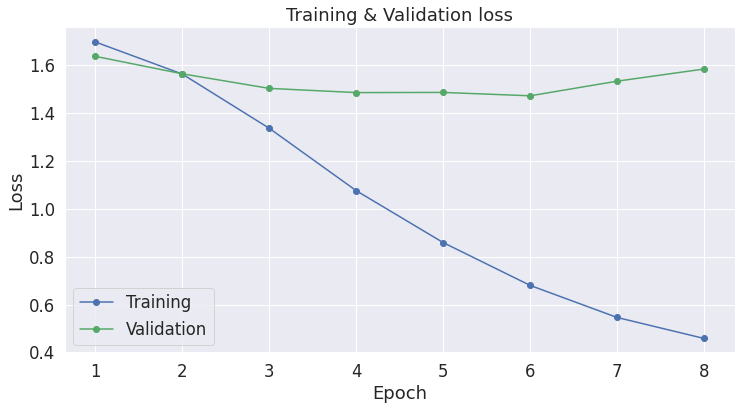

In [ ]:
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4, 5, 6, 7, 8])

plt.show()

We do appear to be severely over-fitting from the third epoch.

# Part III - Performance & Analysis

## S8. Performance On Test Set

### 8.1. Baseline Implementation


The quick summary:
* It uses `tf-idf` for vectorization.
* It uses `multinomial naive bayes` for classification.


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics

# Rename our dataset variables to be consistent with the example.
liar_liar_train = train
liar_liar_test = test

# Vectorize the text using tf-idf.
vectorizer = TfidfVectorizer()

# Before we can vectorize the text, the tf-idf model needs
# to analyze the dataset to build a vocabulary and word counts.
print('Analyzing dataset for tf-idf...\n')
vectorizer.fit(liar_liar_train.data)

# Convert the text samples into tf-idf vectors.
print('Vectorizing the text samples...\n')
vectors_train = vectorizer.transform(liar_liar_train.data)
vectors_test = vectorizer.transform(liar_liar_test.data)

print('{:>6,} train samples with {:<7,} features.'.format(vectors_train.shape[0], vectors_train.shape[1]))
print('{:>6,}  test samples with {:<7,} features.'.format(vectors_test.shape[0], vectors_test.shape[1]))

Analyzing dataset for tf-idf...

Vectorizing the text samples...

28,679 train samples with 37,671  features.
 1,267  test samples with 37,671  features.


In [ ]:
# Following the example, we'll use a "multinomial Naive Bayes" classifier.
clf = MultinomialNB(alpha=.01)

# Train the classifier on the training set.
print('Training the Naive Bays classifier...\n')
clf.fit(vectors_train, liar_liar_train.target)

# Run prediction on the test set.
print('Predicting labels for the test set...\n')
pred = clf.predict(vectors_test)

# Use the F1 metric to score our classifier's performance on the test set.
score = metrics.f1_score(liar_liar_test.target, pred, average='macro')

# Print the F1 score!
print('F1 score: {:.3}'.format(score))

Training the Naive Bays classifier...

Predicting labels for the test set...

F1 score: 0.462


### 8.2. Evaluate BERT on Test Set



Now we can apply our fine-tuned BERT model to generate predictions on the test set.

In [ ]:
# Create the DataLoaders.

# Combine the features into a dataset object.
test_data = TensorDataset(test_input_ids, test_attention_masks, test_labels)
print(test_labels)
# Create a sequential sampler--no need to randomize the order!
test_sampler = SequentialSampler(test_data)

# Create the data loader.
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)


# Predict labels for all test set examples.

print('Predicting labels for {:,} test comments...'.format(len(test_input_ids)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Measure elapsed time.
t0 = time.time()

# Predict 
for (step, batch) in enumerate(test_dataloader):
    
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
  
    # Progress update every 50 batches.
    if step % 50 == 0 and not step == 0:
        # Calculate elapsed time in minutes.
        elapsed = format_time(time.time() - t0)
        
        # Report progress.
        print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(test_dataloader), elapsed))


    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
  
    # Telling the model not to compute or store the compute graph, saving memory
    # and speeding up prediction
    with torch.no_grad():
        # Forward pass, calculate logit predictions
        b_input_ids = torch.tensor(b_input_ids).to(device).long()
        outputs = model(b_input_ids, token_type_ids=None, 
                        attention_mask=b_input_mask)

    logits = outputs[0]
    

    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
  
    # Store predictions and true labels
    # print(logits.astype(int))
    predictions.append(logits)
    # print(predictions)
    true_labels.append(label_ids)

print('    DONE.')

tensor([0, 4, 4,  ..., 2, 2, 4])
Predicting labels for 1,267 test comments...


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:48: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


  Batch    50  of     80.    Elapsed: 0:00:08.
    DONE.


To turn our model outputs into actual predictions, we need to:

1. Re-combine the predictions from across all of the batches.
2. Pick a class label for each prediction by choosing the class with the highest output value.

In [ ]:
# Combine the results across the batches.
predictions = np.concatenate(predictions, axis=0)
true_labels = np.concatenate(true_labels, axis=0)

# Take the highest scoring output as the predicted label.
predicted_labels = np.argmax(predictions, axis=1)


print('`predictions` has shape', predictions.shape)
print('`predicted_labels` has shape', predicted_labels.shape)


`predictions` has shape (1267, 6)
`predicted_labels` has shape (1267,)


Let's peek at the model's outputs for the first 10 test samples, along with the correct labels for each.

In [ ]:
# Reduce printing precision for legibility.
np.set_printoptions(precision=2)

print("Predicted:", str(predicted_labels[0:10]))
print("  Correct:", str(true_labels[0:10]))

Predicted: [0 4 4 3 2 0 0 2 0 2]
  Correct: [0 4 4 3 5 0 0 2 0 2]


The metric for the Liar Liar dataset used by the scikit-learn example is the F1 score. Let's see how BERT performed!

In [ ]:
from sklearn import metrics

# Use the F1 metric to score our classifier's performance on the test set.
score = metrics.f1_score(true_labels, predicted_labels, average='macro')

# Print the F1 score!
print('F1 score: {:.3}'.format(score))

F1 score: 0.589


# Conclusion

At this point, we have the following F1 scores:

* Naive Bayes: `0.46`
* BERT:  `0.59`

Hence by adding the truth history to the Liar Liar Dataset , Performing distillation and scraping politifact data, The F1 score has drastically increased compared to the previous F1 Score trained without the truth history
We've outperformed the baseline! 

In [ ]:
print(model)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

# Saving the model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
output_dir = model.save_pretrained('./saved_model_new/')


In [ ]:
output_dir = tokenizer.save_pretrained('./saved_model_new/')